# SMTS Algorithm for Dynamic Output Classification

First, we create the temperature adjustment model in R.

![title](tempadjmodel.png)

In [1]:
temp = function(art0, prt0, alpha, beta, drt, finaltime, dt){

    # art: Actual Room Temperature
    # prt: Perceived Room Temperature
    # art0: Initial Actual Room Temperature
    # prt0: Initial Perceived Room Temperature
    # alpha: Temperature Adjustment Delay
    # beta: Perception Delay
    # drt: Desired Room Temperature (Theta)
    # finaltime: Simulation Final Time
    # dt: Simulation Time Step
    
    # Function returns a two-column output; the first column is Actual Room Temperature
    # and the second column is Perceived Room Temperature
    
    # Stocks

    art = rep(NA, finaltime / dt + 1)
    art[1] = art0
    prt = rep(NA, finaltime / dt + 1)
    prt[1] = prt0

    #Auxilaries

    alpha = alpha
    beta = beta
    drt = drt
    
    # Simulate
    
    for (i in 1:(finaltime / dt)){

        rtc = ((drt - prt[i]) / alpha) * dt
        pc = ((art[i] - prt[i]) / beta) * dt

        art[i + 1] = art[i] + rtc
        prt[i + 1] = prt[i] + pc

    }

    art = art[seq(1, length(art), 1 / dt)]
    prt = prt[seq(1, length(prt), 1 / dt)]

    return(cbind(art, prt))

}

![](C:\Users\Mert\Desktop)

Below, we run the model for one parameter combination and visualize the results.

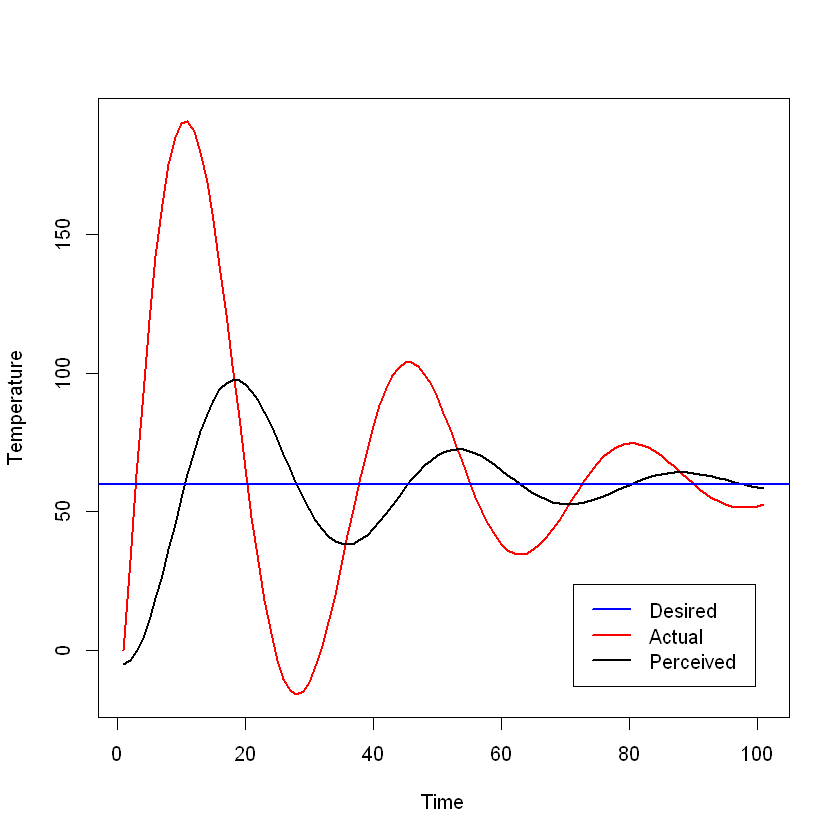

In [2]:
# An example run and its visualization
# You can chance parameter values and initial conditions given below:

art0 = 0
prt0 = -5
alpha = 2
beta = 15
drt = 60
finaltime = 100
dt = 0.125

run = temp(art0 = art0, prt0 = prt0, alpha = alpha, beta = beta, drt = drt, finaltime = finaltime, dt = dt)
plot(run[, 1], col = "red", type = "l", ylab = "Temperature", xlab = "Time", lwd = 2, ylim = c(min(run), max(run)))
lines(run[, 2], col = "black", lwd = 2)
abline(h = drt, col = "blue", lwd = 2)
legend("bottomright", inset = 0.05, legend = c("Desired", "Actual", "Perceived"), lty = c(1, 1, 1), col = c("blue", "red", "black"), lwd = c(2, 2, 2))

Below, we run the model for $ \alpha \in \{1, 2, \ldots, 21\} $ and $ \beta \in \{1, 2, \ldots, 21\} $. Model output is selected as "Actual Room Temperature".

In [7]:
art0 = 0
prt0 = -10
alpha = 11
beta = 20
drt = 20
finaltime = 100
dt = 0.125

result = NULL
for (i in seq(1, 30, 1)){
    for (j in seq(1, 30, 1)){
        result = rbind(result, c(i, j, temp(art0 = art0, prt0 = prt0, alpha = i, beta = j, drt = drt, finaltime = finaltime, dt = dt)[, 1]))
    }
}
print("Run is finished!")

[1] "Run is finished!"


In [8]:
source('train_smts.r')

Joining by: x


[1] "Rep   Fold\tR   Jins   Jts   OOB(E)   Test(E)   (T)R   (T)Jins   (T)Overall   (T)Train   (T)Test"
[1] "Training is finished!"


[1] "Map produced!"


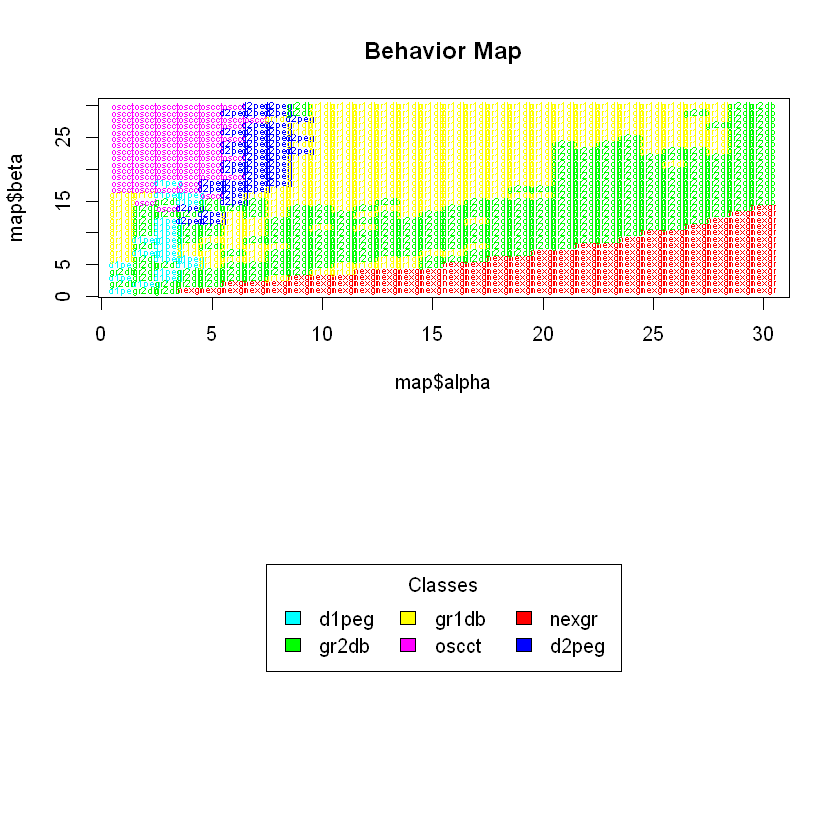

In [9]:
result[, 1] = predicted

label = c("nexgr", "pexgr", "gr1da", "gr1db", "gr2da", "gr2db", "d1peg", "d2peg", "sshgr", "plinr", "oscct")

resultfactor = factor(result[, 1], levels = 1:11, labels = c("nexgr", "pexgr", "gr1da", "gr1db", "gr2da", "gr2db", "d1peg", "d2peg", "sshgr", "plinr", "oscct"))

### Behavior Map ###

map = as.data.frame(cbind(params, predicted))
colnames(map) = c("alpha", "beta", "class")
color = rainbow(length(unique(map$class)))
# colors = c("darkblue", "red", "magenta", "green4", "orange4", "slateblue4", "steelblue4", "pink4", "mediumpurple3", "hotpink", "orangered")

layout(matrix(c(1,2), ncol=1, byrow = TRUE))
plot(x = map$alpha, y = map$beta, main = "Behavior Map", type = "n")
text(x = map$alpha, y = map$beta, labels = as.character(resultfactor), col = color[as.factor(map$class)], cex = 0.5)
plot.new()
legend(x="center", ncol = 3,legend = unique(resultfactor), fill = unique(color[as.factor(map$class)]), title = "Classes")
print("Map produced!")

![title](classes.png)

[1] "Plot is produced!"


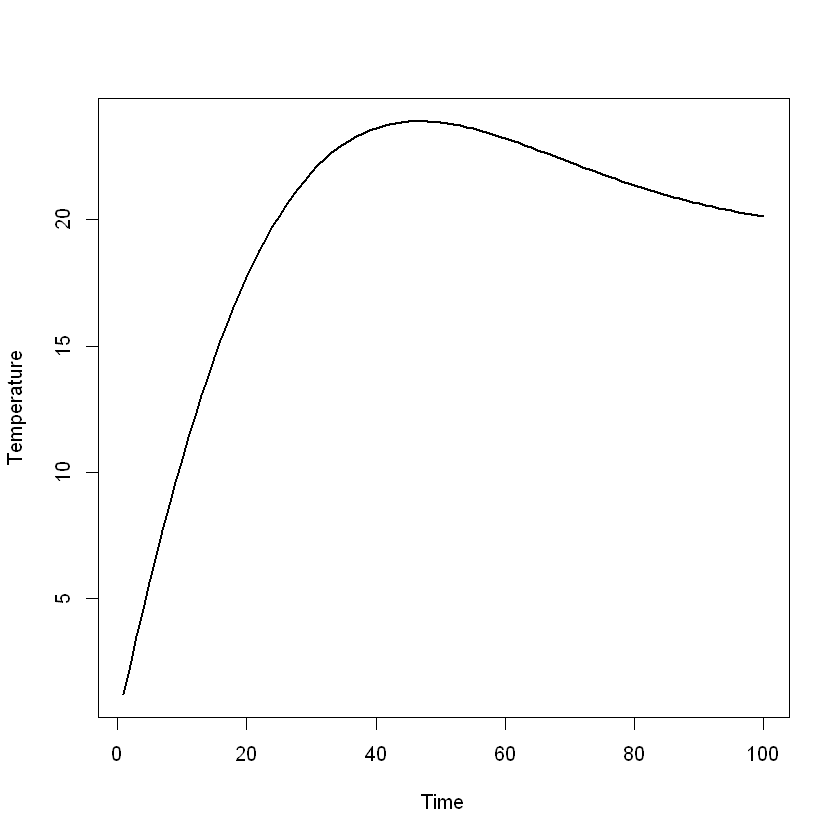

In [10]:
plot(result[which(map$alpha == 25 & map$beta == 15), 3:ncol(result)], type = "l", lwd = 2, xlab = "Time", ylab = "Temperature") 
print("Plot is produced!")

[1] "Plot is produced!"


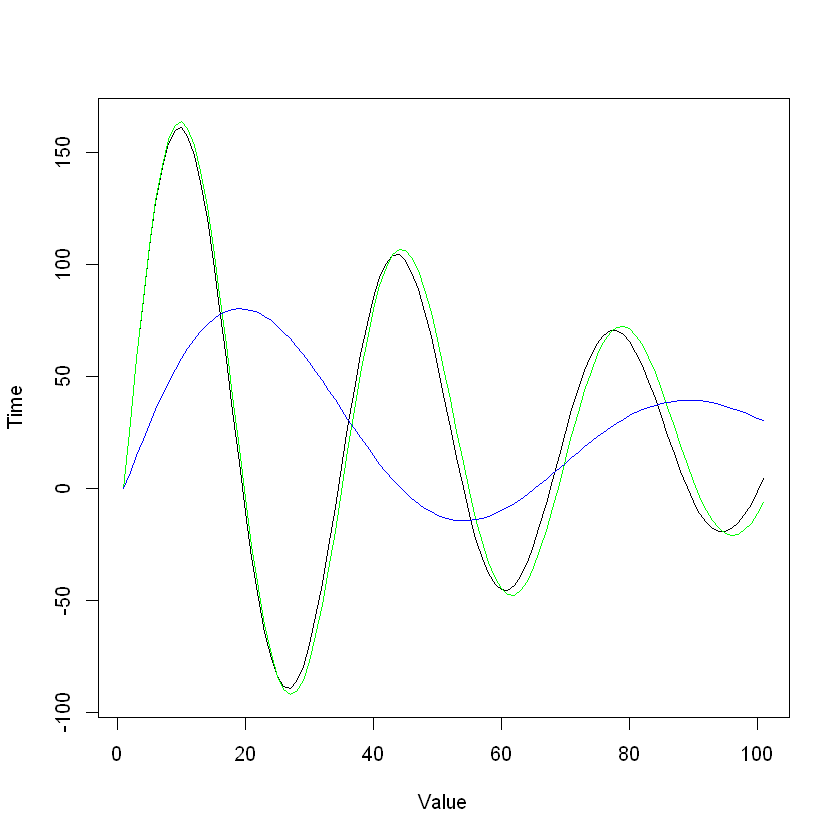

In [11]:
### Calculate Probability of Each Class ###

probs = predict(RFts, codetst, type = 'prob')
dc = cbind.data.frame(c(1:dim(result)[1]), probs, resultfactor)
colnames(dc) = c("index", "nexgr", "pexgr", "gr1da", "gr1db", "gr2da", "gr2db", "d1peg", "d2peg", "sshgr", "plinr", "oscct", "class")

idx = which(dc$oscct > 0.50)
if (length(idx) != 0){
    plot(result[idx[1], 2:dim(result)[2]], ylim = c(min(result[idx, 2:dim(result)[2]]), max(result[idx, 2:dim(result)[2]])), type = "l", main = label[as.numeric(i)], xlab = "Value", ylab = "Time")
    colors = rainbow(length(idx)) 
    for(j in 2:length(idx)){
        lines(result[idx[j], 2:dim(result)[2]], col = colors[j])
    }
    print("Plot is produced!")   
} else {
    print("Cannot find any time series!")
}

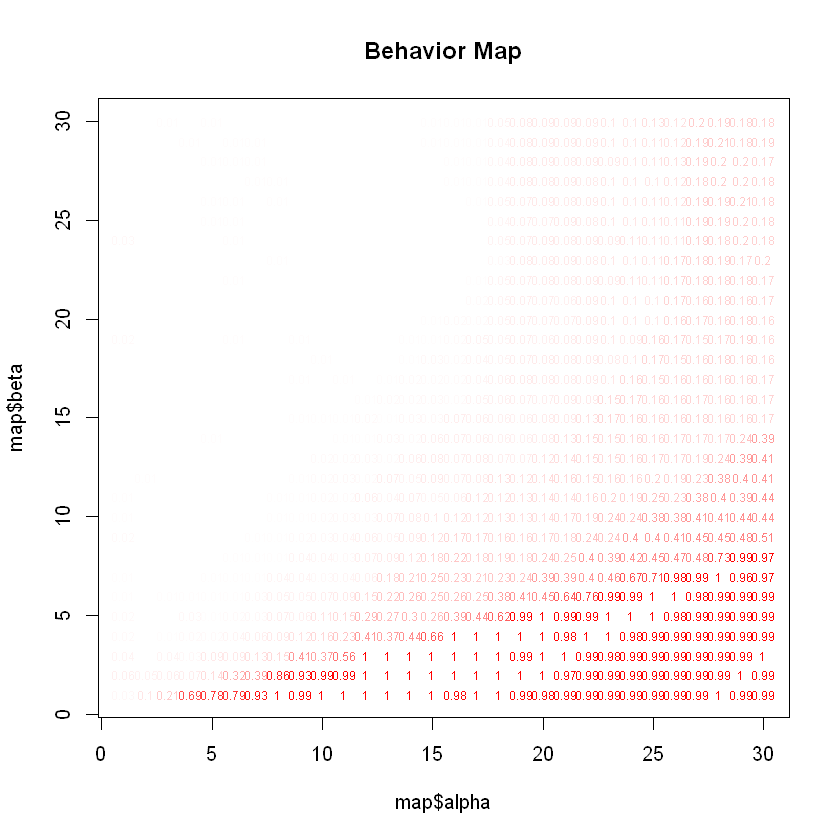

In [10]:
### Behavior Map for a Class ###

map = as.data.frame(cbind(params, dc$nexgr))
colnames(map) = c("alpha", "beta", "probs")
cr = colorRamp(c("white", "red"))

plot(x = map$alpha, y = map$beta, main = "Behavior Map", type = "n")
text(x = map$alpha, y = map$beta, labels = as.character(map$probs), cex = 0.6, col = rgb(cr(map$probs / 1), max = 255))